In [1]:
import re
import os
import math
import time
from pathlib import Path

import requests
import osmread

import pandas as pd

from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher, BaseMatcher
from leuvenmapmatching import visualization as mmviz

In [9]:
xml_file = Path(".") / "osm.xml"
url = 'http://overpass-api.de/api/map?bbox=114.008285,22.582305,114.039957,22.626242'
r = requests.get(url, stream=True)
with xml_file.open('wb') as ofile:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            ofile.write(chunk)

In [29]:
map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)
for entity in osmread.parse_file(str(xml_file)):
    if isinstance(entity, osmread.Way) and 'highway' in entity.tags:
        for node_a, node_b in zip(entity.nodes, entity.nodes[1:]):
            map_con.add_edge(node_a, node_b)
            # Some roads are one-way. We'll add both directions.
            map_con.add_edge(node_b, node_a)
    if isinstance(entity, osmread.Node):
        map_con.add_node(entity.id, (entity.lat, entity.lon))
map_con.purge()

In [30]:
class GisTransform(object):
    """gis坐标转换类"""
 
    def __init__(self, old_gis_name, new_gis_name):
        """
        经纬度(谷歌高德):'wgs84'/  墨卡托:'webMercator'/ 火星坐标系(国测局):'gcj02'
        """
        self.pi = 3.1415926535897932384626  # π   精度比math.pi 还高一些
        self.ee = 0.00669342162296594323  # 偏心率平方
        self.a = 6378245.0  # 长半轴
 
        func_name = old_gis_name + '_to_' + new_gis_name
        if hasattr(self, func_name):
            self.transform_func = getattr(self, func_name)
 
    def _out_of_china(self, lng, lat):
        """
        判断是否在国内，不在国内不做偏移
        :param lng:
        :param lat:
        :return:
        """
        return not (lng > 73.66 and lng < 135.05 and lat > 3.86 and lat < 53.55)
 
    def _transformlat(self, lng, lat):
        ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
              0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
        ret += (20.0 * math.sin(6.0 * lng * self.pi) + 20.0 *
                math.sin(2.0 * lng * self.pi)) * 2.0 / 3.0
        ret += (20.0 * math.sin(lat * self.pi) + 40.0 *
                math.sin(lat / 3.0 * self.pi)) * 2.0 / 3.0
        ret += (160.0 * math.sin(lat / 12.0 * self.pi) + 320 *
                math.sin(lat * self.pi / 30.0)) * 2.0 / 3.0
        return ret
 
    def _transformlng(self, lng, lat):
        ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
              0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
        ret += (20.0 * math.sin(6.0 * lng * self.pi) + 20.0 *
                math.sin(2.0 * lng * self.pi)) * 2.0 / 3.0
        ret += (20.0 * math.sin(lng * self.pi) + 40.0 *
                math.sin(lng / 3.0 * self.pi)) * 2.0 / 3.0
        ret += (150.0 * math.sin(lng / 12.0 * self.pi) + 300.0 *
                math.sin(lng / 30.0 * self.pi)) * 2.0 / 3.0
        return ret
 
    def wgs84_to_webMercator(self, lon, lat):
        """wgs84坐标 转 墨卡托坐标"""
        x = lon * 20037508.342789 / 180
        y = math.log(math.tan((90 + lat) * self.pi / 360)) / (self.pi / 180)
        y = y * 20037508.34789 / 180
        return x, y
 
    def gcj02_to_webMercator(self, x, y):
        """火星转墨卡托"""
        wgs84_x, wgs84_y = self.gcj02_to_wgs84(x, y)
        webMercator_x, webMercator_y = self.wgs84_to_webMercator(wgs84_x, wgs84_y)
        return webMercator_x, webMercator_y
 
    def webMercator_to_webMercator(self, x, y):
        return x, y
 
    def webMercator_to_wgs84(self, x, y):
        """墨卡托坐标 转 wgs84坐标"""
        lon = x / 20037508.34 * 180
        lat = y / 20037508.34 * 180
        lat = 180 / self.pi * (2 * math.atan(math.exp(lat * self.pi / 180)) - self.pi / 2)
        return lon, lat
 
    def gcj02_to_wgs84(self, lng, lat):
        """
        GCJ02(火星坐标系)转GPS84
        :param lng:火星坐标系的经度
        :param lat:火星坐标系纬度
        :return:
        """
        if self._out_of_china(lng, lat):
            return lng, lat
        dlat = self._transformlat(lng - 105.0, lat - 35.0)
        dlng = self._transformlng(lng - 105.0, lat - 35.0)
        radlat = lat / 180.0 * self.pi
        magic = math.sin(radlat)
        magic = 1 - self.ee * magic * magic
        sqrtmagic = math.sqrt(magic)
        dlat = (dlat * 180.0) / ((self.a * (1 - self.ee)) / (magic * sqrtmagic) * self.pi)
        dlng = (dlng * 180.0) / (self.a / sqrtmagic * math.cos(radlat) * self.pi)
        mglat = lat + dlat
        mglng = lng + dlng
        new_x = lng * 2 - mglng
        new_y = lat * 2 - mglat
        return new_x, new_y
 
    def wgs84_to_gcj02(self, lng, lat):
        """
        WGS84转GCJ02(火星坐标系)
        :param lng:WGS84坐标系的经度
        :param lat:WGS84坐标系的纬度
        :return:
        """
        if self._out_of_china(lng, lat):  # 判断是否在国内
            return lng, lat
        dlat = self._transformlat(lng - 105.0, lat - 35.0)
        dlng = self._transformlng(lng - 105.0, lat - 35.0)
        radlat = lat / 180.0 * self.pi
        magic = math.sin(radlat)
        magic = 1 - self.ee * magic * magic
        sqrtmagic = math.sqrt(magic)
        dlat = (dlat * 180.0) / ((self.a * (1 - self.ee)) / (magic * sqrtmagic) * self.pi)
        dlng = (dlng * 180.0) / (self.a / sqrtmagic * math.cos(radlat) * self.pi)
        mglat = lat + dlat
        mglng = lng + dlng
        return mglng, mglat
 
    def webMercator_to_gcj02(self, x, y):
        """墨卡托转火星"""
        wgs84_x, wgs84_y = self.webMercator_to_wgs84(x, y)
        gcj02_x, gcj02_y = self.wgs84_to_gcj02(wgs84_x, wgs84_y)
        return gcj02_x, gcj02_y

In [31]:
f = open('../20191201_20191220.csv')

In [38]:
gis = GisTransform('gcj02', 'wgs84')
matcher = DistanceMatcher(map_con,
                          max_dist=100,
                          non_emitting_states=False)
since = time.time()
for i in range(12):
    
    # Load a trj
    line = f.readline()
    
    # preprocess
    coords = line.replace('[','').replace(']','').replace('"','').split(',')[2:]
    coords = [item.replace('\n','') for item in coords]
    coords = [item.split(' ')[:3] for item in coords]
    coords = np.array(coords[1:])[:,1:].astype(float).tolist()
    coords = [(lon, lat) for [lon, lat] in coords]
    coords_new = [gis.transform_func(lon, lat) for (lon, lat) in coords]
    coords_new = [(lat, lon) for (lon, lat) in coords_new]

    # match
    try:
        states, lastidx = matcher.match(coords_new)
    except:
        continue
    
    # duration
    if i % 5 == 0:
        print("[Info] Matched Trj [{:d}] | duration: {:.1f} sec.".format(i,
                                                                         time.time() - since))

In [39]:
mmviz.plot_map(map_con, matcher=matcher,
               show_labels=False, show_matching=True, show_graph=True,
               filename="my_plot.png")

(None, None)

(None, <matplotlib.axes._subplots.AxesSubplot at 0x23f29ca9940>)

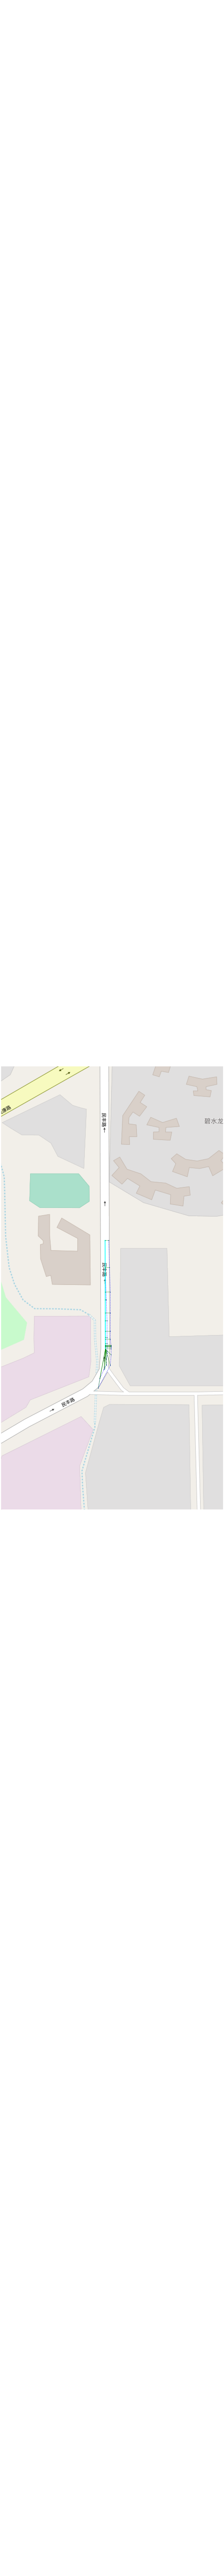

In [40]:
mmviz.plot_map(map_con, matcher=matcher,
               use_osm=True, zoom_path=True,
               show_labels=False, show_matching=True, show_graph=False,
               filename="my_osm_plot.png")